In [34]:
import csv
import logging
import numpy as np
import pandas as pd
import pprint
import datetime

logging.basicConfig(level=logging.DEBUG)

In [35]:
# Pull in data Sources
beds = pd.read_csv("data/beds.csv")
populations = pd.read_csv("data/populations.csv")
full_timeseries = pd.read_csv('data/timeseries.csv')

In [36]:
# Modeling Assumptions
r0_initial = 2.4
hospitalization_rate = .073
initial_hospitalization_rate = .05
case_fatality_rate = .011
case_fatality_rate_hospitals_overwhelmed = .01
hospital_capacity_change_daily_rate = 1.05
max_hospital_capacity_factor = 2.08
initial_hospital_bed_utilization = .6
model_interval = 4
rolling_intervals_for_current_infected = 3

In [37]:
# Helper functions
def get_population(state, country):
    matching_pops = populations[(populations["state"] == state) & (
        populations["country"] == country)]
    return int(matching_pops.iloc[0].at["population"])


def get_beds(state, country):
    matching_beds = beds[(beds["state"] == state) &
                         (beds["country"] == country)]
    beds_per_mille = float(matching_beds.iloc[0].at["bedspermille"])
    return int(round(beds_per_mille * get_population(state, country) / 1000))


def get_snapshot(date, state, country):
    # First, attempt to pull the state-level data without aggregating.
    filtered_timeseries = full_timeseries[(full_timeseries["state"] == state) & (
        full_timeseries["country"] == country) & (full_timeseries['date'] == date.strftime('%Y-%m-%d')) & (full_timeseries["county"].isna())]

    #pprint.pprint(filtered_timeseries)

    # Switch to aggregating across counties if that returns no cases.
    if int(filtered_timeseries['cases'].sum()) == 0:
          filtered_timeseries = full_timeseries[(full_timeseries["state"] == state) & (
              full_timeseries["country"] == country) & (full_timeseries['date'] == date.strftime('%Y-%m-%d'))]

    #pprint.pprint(filtered_timeseries)

    confirmed = None
    deaths = 0
    recovered = 0

    try:
        #row = filtered_snapshot.iloc[0]
        confirmed = int(filtered_timeseries['cases'].sum())
        deaths = int(filtered_timeseries['recovered'].sum())
        recovered = int(filtered_timeseries['deaths'].sum())
    except IndexError as e:
        pass

    return {'confirmed': confirmed, 'deaths': deaths, 'recovered': recovered}

In [38]:
# Calculation functions. Each encapsulates the logic needed to calculate one of the model variables

def calculate_r0(snapshot, previous_snapshot):
    # Calculate the r0 value based on the current and past number of confirmed cases
    previous_confirmed = previous_snapshot['confirmed']
    effective_r0 = r0_initial
    if snapshot['confirmed'] is not None and previous_confirmed > 0:
        effective_r0 = snapshot['confirmed'] / previous_confirmed
    return effective_r0 

def calculate_newly_infected(snapshot, previous_snapshot, pop):
    previous_newly_infected = previous_snapshot['newly_infected']
    previous_ending_susceptible = previous_snapshot['ending_susceptible']
    effective_r0 = snapshot['effective_r0']
    if previous_newly_infected > 0:
        # If we have previously known cases, use the R0 to estimate newly infected cases.
        newly_infected = previous_newly_infected * \
            effective_r0 * previous_ending_susceptible / pop
    else:
        # We assume the first positive cases were exclusively hospitalized ones.
        actual_infected_vs_tested_positive = 1 / initial_hospitalization_rate  # ~20
        if snapshot['confirmed'] is not None:
            confirmed = snapshot['confirmed']
        newly_infected = snapshot['confirmed'] * \
            actual_infected_vs_tested_positive
    return newly_infected

def calculate_previously_infected(snapshot_series, rolling_intervals_for_current_infected):
    return sum(
            ss['newly_infected'] for ss in snapshot_series[-rolling_intervals_for_current_infected:]
    )

def calculate_cumulative_deaths(snapshot, previous_snapshot, case_fatality_rate, case_fatality_rate_hospitals_overwhelmed, logged_overwhelmed, state):
    snapshot_date = snapshot['date']
    predicted_hospitalized = snapshot['predicted_hospitalized']
    newly_infected = snapshot['newly_infected'] # ASSUMPTION: For this calculation we care about the # of newly infected for this iteration, not the previous iteration
    cumulative_deaths = previous_snapshot['cumulative_deaths']
    available_hospital_beds = previous_snapshot['available_hospital_beds'] # ASSUMPTION: We want yesterdays number, not todays. If we want todays, then the hospital bed calc needs to come before this one
    if (available_hospital_beds > predicted_hospitalized):
            cumulative_deaths += int(round(newly_infected *
                                           case_fatality_rate))
    else:
        if not logged_overwhelmed:
            logging.info('Hospitals in {} overwhelmed on {}'.format(state, snapshot_date))
        logged_overwhelmed = True
        cumulative_deaths += int(round(newly_infected *
                                       (case_fatality_rate_hospitals_overwhelmed + case_fatality_rate_hospitals_overwhelmed)))
    return cumulative_deaths
    
def calcluate_recovered_or_died(snapsnot, previous_snapshot, snapshot_series, rolling_intervals_for_current_infected):
    if len(snapshot_series) >= 4:
        recovered_or_died = previous_snapshot['recovered_or_died'] 
        recovered_or_died = recovered_or_died + \
                    snapshot_series[-rolling_intervals_for_current_infected-1]['newly_infected']
        return recovered_or_died
    else:
        return previous_snapshot['recovered_or_died']

def calculate_ending_susceptible(snapshot, previous_snapshot, pop):
    newly_infected = snapshot['newly_infected']
    recovered_or_died = snapshot['recovered_or_died']
    previously_infected = snapshot['previously_infected']
    ending_susceptible = int(round(
            pop - newly_infected - previously_infected - recovered_or_died))
    return ending_susceptible

def calculate_estimated_actual_chance_of_infection(snapshot, previous_snapshot, hospitalization_rate, pop):
    est_actual_chance_of_infection = None
    actual_reported = 0
    if snapshot['confirmed'] is not None:
        est_actual_chance_of_infection = (
            snapshot['confirmed'] / hospitalization_rate * 2) / pop
        
def calculate_actual_reported(snapshot, previous_snapshot):
    actual_reported = 0
    if snapshot['confirmed'] is not None:
        actual_reported = int(round(snapshot['confirmed']))
        
def calculate_available_hospital_beds(snapshot, previous_snapshot, max_hospital_capacity_factor, original_available_hospital_beds, hospital_capacity_change_daily_rate):
    available_hospital_beds = previous_snapshot['available_hospital_beds']
    if available_hospital_beds < max_hospital_capacity_factor * original_available_hospital_beds:
            available_hospital_beds *= hospital_capacity_change_daily_rate
    return available_hospital_beds

In [39]:
"""
The guts. Creates the initial conditions, then iterates the model over the data for a specified number
of iterations
"""
def iterate_model(iterations, country, state, pop, beds):
    # @TODO: See if today's data is already available. If so, don't subtract an additional day.
    # @TODO: Switch back to 1 after testing
    today = datetime.date.today() - datetime.timedelta(days=1)
    # Set the initial snapshot date
    snapshot_date = today - datetime.timedelta(days=model_interval *
                                                    rolling_intervals_for_current_infected)
    original_available_hospital_beds = round(
        beds * (1 - initial_hospital_bed_utilization), 0
    ) 
    init_snapshot = {
        'date': snapshot_date,
        'effective_r0': 0,
        'confirmed': 0,
        'actual_reported': 0,
        'previously_infected': 0,
        'est_actual_chance_of_infection': 0,
        'newly_infected': 0,
        'current_infected': 0,
        'cumulative_infected': 0,
        'cumulative_deaths': 0,
        'recovered_or_died': 0,
        'ending_susceptible': pop,
        'predicted_hospitalized': 0,
        'available_hospital_beds': original_available_hospital_beds

    }
    snapshot_series = [init_snapshot, ]
    previous_snapshot = init_snapshot
    logged_overwhelmed = False
    while True:
        # Step through existing empirical data
        if snapshot_date <= today:
            snapshot = get_snapshot(snapshot_date, state, country)
        # If the snapshot date is past today's date, we're projecting from here on out
        else:
            snapshot = {'confirmed': None, 'deaths': None, 'recovered': None}
        snapshot['date'] = snapshot_date

        # Run the model until enough iterations are complete.
        if snapshot['date'] > today + datetime.timedelta(days=iterations * model_interval):
            break  # @TODO change to work predictively
        logging.debug('Calculating values for {}'.format(snapshot['date']))
        # Calculate the r0 value
        snapshot['effective_r0'] = calculate_r0(snapshot, previous_snapshot)
        # Calculate the number of newly infected cases
        snapshot['newly_infected'] = calculate_newly_infected(
            snapshot,
            previous_snapshot,
            pop
        )
        # Assume infected cases from before the rolling interval have concluded.
        snapshot['recovered_or_died'] = calcluate_recovered_or_died(
            snapshot,
            previous_snapshot,
            snapshot_series,
            rolling_intervals_for_current_infected
        )
        # Calculate the number of people who have already been infected
        snapshot['previously_infected'] = calculate_previously_infected(
            snapshot_series,
            rolling_intervals_for_current_infected
        )
        # Calculate the cumulative number of infected individuals
        snapshot['cumulative_infected'] = previous_snapshot['cumulative_infected'] + snapshot['newly_infected']
        # Predict the number of patients that will require hospitilzation
        snapshot['predicted_hospitalized'] = snapshot['newly_infected'] * hospitalization_rate
        # Calculate the number of cumulative deaths
        snapshot['cumulative_deaths'] = calculate_cumulative_deaths(
            snapshot,
            previous_snapshot,
            case_fatality_rate,
            case_fatality_rate_hospitals_overwhelmed,
            logged_overwhelmed,
            state
        )
        # Recalculate the estimated chance of infection
        snapshot['est_actual_chance_of_infection'] = calculate_estimated_actual_chance_of_infection(
            snapshot,
            previous_snapshot,
            hospitalization_rate,
            pop
        )
        # Note the actual number of reported cases
        snapshot['actual_reported'] = calculate_actual_reported(snapshot, previous_snapshot)
        # Recalculate how many people are susceptible at the end of the cycle
        snapshot['ending_susceptible'] = calculate_ending_susceptible(snapshot, previous_snapshot, pop)
        # Recalculate how many hospital beds are left
        snapshot['available_hospital_beds'] = calculate_available_hospital_beds(
            snapshot,
            previous_snapshot,
            max_hospital_capacity_factor,
            original_available_hospital_beds,
            hospital_capacity_change_daily_rate
        )
        # Prepare for the next iteration
        snapshot_series.append(snapshot)
        previous_snapshot = snapshot
        # Advance the clock
        snapshot_date += datetime.timedelta(days=model_interval)
    return snapshot_series

In [40]:
def forecast_region(state, country, iterations):
    logging.info('Building results for {} in {}'.format(state, country))
    pop = get_population(state, country)
    beds = get_beds(state, country)
    logging.debug('This location has {} beds for {} people'.format(beds, pop))
    logging.debug('Loading daily report from {} days ago'.format(model_interval))

    snapshot_series = iterate_model(iterations, country, state, pop, beds)

    forecast = pd.DataFrame({
        'Note': ['' for s in snapshot_series],
        'Date': [s['date'] for s in snapshot_series],
        'Timestamp': [datetime.datetime(year=s['date'].year, month=s['date'].month, day=s['date'].day).timestamp() for s in snapshot_series],
        'Eff. R0': [s['effective_r0'] for s in snapshot_series],
        'Beg. Susceptible': [s['ending_susceptible'] for s in snapshot_series],
        'New Inf.': [s['effective_r0'] for s in snapshot_series],
        'Prev. Inf.': [s['previously_infected'] for s in snapshot_series],
        'Recov. or Died': [s['recovered_or_died'] for s in snapshot_series],
        'End Susceptible': [s['ending_susceptible'] for s in snapshot_series],
        'Actual Reported': [s['actual_reported'] for s in snapshot_series],
        'Pred. Hosp.': [s['predicted_hospitalized'] for s in snapshot_series],
        'Cum. Inf.': [s['cumulative_infected'] for s in snapshot_series],
        'Cum. Deaths': [s['cumulative_deaths'] for s in snapshot_series],
        'Avail. Hosp. Beds': [s['available_hospital_beds'] for s in snapshot_series],
        'S&P 500': [None for s in snapshot_series],
        'Est. Actual Chance of Inf.': [s['est_actual_chance_of_infection'] for s in snapshot_series],
        'Pred. Chance of Inf.': [None for s in snapshot_series],
        'Cum. Pred. Chance of Inf.': [None for s in snapshot_series],
        'R0': [None for s in snapshot_series],
        '% Susceptible': [None for s in snapshot_series]
    })
    return forecast

ak = forecast_region('AK', 'USA', 25)

INFO:root:Building results for AK in USA
DEBUG:root:This location has 1609 beds for 731545 people
DEBUG:root:Loading daily report from 4 days ago
DEBUG:root:Calculating values for 2020-03-07
DEBUG:root:Calculating values for 2020-03-11
DEBUG:root:Calculating values for 2020-03-15
DEBUG:root:Calculating values for 2020-03-19
DEBUG:root:Calculating values for 2020-03-23
DEBUG:root:Calculating values for 2020-03-27
DEBUG:root:Calculating values for 2020-03-31
DEBUG:root:Calculating values for 2020-04-04
DEBUG:root:Calculating values for 2020-04-08
DEBUG:root:Calculating values for 2020-04-12
INFO:root:Hospitals in AK overwhelmed on 2020-04-12
DEBUG:root:Calculating values for 2020-04-16
INFO:root:Hospitals in AK overwhelmed on 2020-04-16
DEBUG:root:Calculating values for 2020-04-20
INFO:root:Hospitals in AK overwhelmed on 2020-04-20
DEBUG:root:Calculating values for 2020-04-24
INFO:root:Hospitals in AK overwhelmed on 2020-04-24
DEBUG:root:Calculating values for 2020-04-28
INFO:root:Hospit

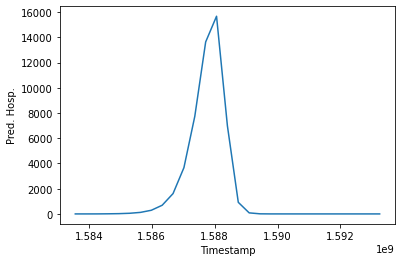

In [42]:
import seaborn as sb

sb.lineplot(x='Timestamp', y='Pred. Hosp.', data=ak)

In [24]:
# aaaaaand MAGIC. Generate all of the forecasts for all of the states.
states = populations['state'].tolist()
for state in states:
    forecast = forecast_region(state, 'USA', 25)
    forecast.to_csv(path_or_buf='results/{}.csv'.format(state), index=False)

INFO:root:Building results for CA in USA
DEBUG:root:This location has 71122 beds for 39512223 people
DEBUG:root:Loading daily report from 4 days ago
DEBUG:root:Calculating values for 2020-03-07
DEBUG:root:Calculating values for 2020-03-11
DEBUG:root:Calculating values for 2020-03-15
DEBUG:root:Calculating values for 2020-03-19
DEBUG:root:Calculating values for 2020-03-23
DEBUG:root:Calculating values for 2020-03-27
DEBUG:root:Calculating values for 2020-03-31
DEBUG:root:Calculating values for 2020-04-04
INFO:root:Hospitals in CA overwhelmed on 2020-04-04
DEBUG:root:Calculating values for 2020-04-08
INFO:root:Hospitals in CA overwhelmed on 2020-04-08
DEBUG:root:Calculating values for 2020-04-12
INFO:root:Hospitals in CA overwhelmed on 2020-04-12
DEBUG:root:Calculating values for 2020-04-16
INFO:root:Hospitals in CA overwhelmed on 2020-04-16
DEBUG:root:Calculating values for 2020-04-20
INFO:root:Hospitals in CA overwhelmed on 2020-04-20
DEBUG:root:Calculating values for 2020-04-24
INFO:r

DEBUG:root:Calculating values for 2020-05-02
INFO:root:Hospitals in PA overwhelmed on 2020-05-02
DEBUG:root:Calculating values for 2020-05-06
DEBUG:root:Calculating values for 2020-05-10
DEBUG:root:Calculating values for 2020-05-14
DEBUG:root:Calculating values for 2020-05-18
DEBUG:root:Calculating values for 2020-05-22
DEBUG:root:Calculating values for 2020-05-26
DEBUG:root:Calculating values for 2020-05-30
DEBUG:root:Calculating values for 2020-06-03
DEBUG:root:Calculating values for 2020-06-07
DEBUG:root:Calculating values for 2020-06-11
DEBUG:root:Calculating values for 2020-06-15
DEBUG:root:Calculating values for 2020-06-19
DEBUG:root:Calculating values for 2020-06-23
DEBUG:root:Calculating values for 2020-06-27
INFO:root:Building results for IL in USA
DEBUG:root:This location has 31680 beds for 12671821 people
DEBUG:root:Loading daily report from 4 days ago
DEBUG:root:Calculating values for 2020-03-07
DEBUG:root:Calculating values for 2020-03-11
DEBUG:root:Calculating values for 

DEBUG:root:Calculating values for 2020-03-27
DEBUG:root:Calculating values for 2020-03-31
DEBUG:root:Calculating values for 2020-04-04
INFO:root:Hospitals in MI overwhelmed on 2020-04-04
DEBUG:root:Calculating values for 2020-04-08
INFO:root:Hospitals in MI overwhelmed on 2020-04-08
DEBUG:root:Calculating values for 2020-04-12
INFO:root:Hospitals in MI overwhelmed on 2020-04-12
DEBUG:root:Calculating values for 2020-04-16
INFO:root:Hospitals in MI overwhelmed on 2020-04-16
DEBUG:root:Calculating values for 2020-04-20
INFO:root:Hospitals in MI overwhelmed on 2020-04-20
DEBUG:root:Calculating values for 2020-04-24
INFO:root:Hospitals in MI overwhelmed on 2020-04-24
DEBUG:root:Calculating values for 2020-04-28
INFO:root:Hospitals in MI overwhelmed on 2020-04-28
DEBUG:root:Calculating values for 2020-05-02
DEBUG:root:Calculating values for 2020-05-06
DEBUG:root:Calculating values for 2020-05-10
DEBUG:root:Calculating values for 2020-05-14
DEBUG:root:Calculating values for 2020-05-18
DEBUG:

DEBUG:root:Calculating values for 2020-05-18
DEBUG:root:Calculating values for 2020-05-22
DEBUG:root:Calculating values for 2020-05-26
DEBUG:root:Calculating values for 2020-05-30
DEBUG:root:Calculating values for 2020-06-03
DEBUG:root:Calculating values for 2020-06-07
DEBUG:root:Calculating values for 2020-06-11
DEBUG:root:Calculating values for 2020-06-15
DEBUG:root:Calculating values for 2020-06-19
DEBUG:root:Calculating values for 2020-06-23
DEBUG:root:Calculating values for 2020-06-27
INFO:root:Building results for MA in USA
DEBUG:root:This location has 15984 beds for 6949503 people
DEBUG:root:Loading daily report from 4 days ago
DEBUG:root:Calculating values for 2020-03-07
DEBUG:root:Calculating values for 2020-03-11
DEBUG:root:Calculating values for 2020-03-15
DEBUG:root:Calculating values for 2020-03-19
DEBUG:root:Calculating values for 2020-03-23
DEBUG:root:Calculating values for 2020-03-27
DEBUG:root:Calculating values for 2020-03-31
DEBUG:root:Calculating values for 2020-04-

INFO:root:Hospitals in MD overwhelmed on 2020-04-12
DEBUG:root:Calculating values for 2020-04-16
INFO:root:Hospitals in MD overwhelmed on 2020-04-16
DEBUG:root:Calculating values for 2020-04-20
INFO:root:Hospitals in MD overwhelmed on 2020-04-20
DEBUG:root:Calculating values for 2020-04-24
INFO:root:Hospitals in MD overwhelmed on 2020-04-24
DEBUG:root:Calculating values for 2020-04-28
INFO:root:Hospitals in MD overwhelmed on 2020-04-28
DEBUG:root:Calculating values for 2020-05-02
INFO:root:Hospitals in MD overwhelmed on 2020-05-02
DEBUG:root:Calculating values for 2020-05-06
DEBUG:root:Calculating values for 2020-05-10
DEBUG:root:Calculating values for 2020-05-14
DEBUG:root:Calculating values for 2020-05-18
DEBUG:root:Calculating values for 2020-05-22
DEBUG:root:Calculating values for 2020-05-26
DEBUG:root:Calculating values for 2020-05-30
DEBUG:root:Calculating values for 2020-06-03
DEBUG:root:Calculating values for 2020-06-07
DEBUG:root:Calculating values for 2020-06-11
DEBUG:root:Ca

DEBUG:root:Calculating values for 2020-06-15
DEBUG:root:Calculating values for 2020-06-19
DEBUG:root:Calculating values for 2020-06-23
DEBUG:root:Calculating values for 2020-06-27
INFO:root:Building results for AL in USA
DEBUG:root:This location has 15200 beds for 4903185 people
DEBUG:root:Loading daily report from 4 days ago
DEBUG:root:Calculating values for 2020-03-07
DEBUG:root:Calculating values for 2020-03-11
DEBUG:root:Calculating values for 2020-03-15
DEBUG:root:Calculating values for 2020-03-19
DEBUG:root:Calculating values for 2020-03-23
DEBUG:root:Calculating values for 2020-03-27
DEBUG:root:Calculating values for 2020-03-31
DEBUG:root:Calculating values for 2020-04-04
DEBUG:root:Calculating values for 2020-04-08
DEBUG:root:Calculating values for 2020-04-12
INFO:root:Hospitals in AL overwhelmed on 2020-04-12
DEBUG:root:Calculating values for 2020-04-16
INFO:root:Hospitals in AL overwhelmed on 2020-04-16
DEBUG:root:Calculating values for 2020-04-20
INFO:root:Hospitals in AL ov

DEBUG:root:Calculating values for 2020-04-28
INFO:root:Hospitals in OK overwhelmed on 2020-04-28
DEBUG:root:Calculating values for 2020-05-02
INFO:root:Hospitals in OK overwhelmed on 2020-05-02
DEBUG:root:Calculating values for 2020-05-06
DEBUG:root:Calculating values for 2020-05-10
DEBUG:root:Calculating values for 2020-05-14
DEBUG:root:Calculating values for 2020-05-18
DEBUG:root:Calculating values for 2020-05-22
DEBUG:root:Calculating values for 2020-05-26
DEBUG:root:Calculating values for 2020-05-30
DEBUG:root:Calculating values for 2020-06-03
DEBUG:root:Calculating values for 2020-06-07
DEBUG:root:Calculating values for 2020-06-11
DEBUG:root:Calculating values for 2020-06-15
DEBUG:root:Calculating values for 2020-06-19
DEBUG:root:Calculating values for 2020-06-23
DEBUG:root:Calculating values for 2020-06-27
INFO:root:Building results for CT in USA
DEBUG:root:This location has 7131 beds for 3565287 people
DEBUG:root:Loading daily report from 4 days ago
DEBUG:root:Calculating values

DEBUG:root:Calculating values for 2020-03-11
DEBUG:root:Calculating values for 2020-03-15
DEBUG:root:Calculating values for 2020-03-19
DEBUG:root:Calculating values for 2020-03-23
DEBUG:root:Calculating values for 2020-03-27
DEBUG:root:Calculating values for 2020-03-31
DEBUG:root:Calculating values for 2020-04-04
DEBUG:root:Calculating values for 2020-04-08
DEBUG:root:Calculating values for 2020-04-12
INFO:root:Hospitals in AR overwhelmed on 2020-04-12
DEBUG:root:Calculating values for 2020-04-16
INFO:root:Hospitals in AR overwhelmed on 2020-04-16
DEBUG:root:Calculating values for 2020-04-20
INFO:root:Hospitals in AR overwhelmed on 2020-04-20
DEBUG:root:Calculating values for 2020-04-24
INFO:root:Hospitals in AR overwhelmed on 2020-04-24
DEBUG:root:Calculating values for 2020-04-28
INFO:root:Hospitals in AR overwhelmed on 2020-04-28
DEBUG:root:Calculating values for 2020-05-02
DEBUG:root:Calculating values for 2020-05-06
DEBUG:root:Calculating values for 2020-05-10
DEBUG:root:Calculati

DEBUG:root:Calculating values for 2020-05-30
DEBUG:root:Calculating values for 2020-06-03
DEBUG:root:Calculating values for 2020-06-07
DEBUG:root:Calculating values for 2020-06-11
DEBUG:root:Calculating values for 2020-06-15
DEBUG:root:Calculating values for 2020-06-19
DEBUG:root:Calculating values for 2020-06-23
DEBUG:root:Calculating values for 2020-06-27
INFO:root:Building results for WV in USA
DEBUG:root:This location has 6810 beds for 1792065 people
DEBUG:root:Loading daily report from 4 days ago
DEBUG:root:Calculating values for 2020-03-07
DEBUG:root:Calculating values for 2020-03-11
DEBUG:root:Calculating values for 2020-03-15
DEBUG:root:Calculating values for 2020-03-19
DEBUG:root:Calculating values for 2020-03-23
DEBUG:root:Calculating values for 2020-03-27
DEBUG:root:Calculating values for 2020-03-31
DEBUG:root:Calculating values for 2020-04-04
DEBUG:root:Calculating values for 2020-04-08
DEBUG:root:Calculating values for 2020-04-12
DEBUG:root:Calculating values for 2020-04-1

INFO:root:Hospitals in ME overwhelmed on 2020-04-12
DEBUG:root:Calculating values for 2020-04-16
INFO:root:Hospitals in ME overwhelmed on 2020-04-16
DEBUG:root:Calculating values for 2020-04-20
INFO:root:Hospitals in ME overwhelmed on 2020-04-20
DEBUG:root:Calculating values for 2020-04-24
INFO:root:Hospitals in ME overwhelmed on 2020-04-24
DEBUG:root:Calculating values for 2020-04-28
INFO:root:Hospitals in ME overwhelmed on 2020-04-28
DEBUG:root:Calculating values for 2020-05-02
DEBUG:root:Calculating values for 2020-05-06
DEBUG:root:Calculating values for 2020-05-10
DEBUG:root:Calculating values for 2020-05-14
DEBUG:root:Calculating values for 2020-05-18
DEBUG:root:Calculating values for 2020-05-22
DEBUG:root:Calculating values for 2020-05-26
DEBUG:root:Calculating values for 2020-05-30
DEBUG:root:Calculating values for 2020-06-03
DEBUG:root:Calculating values for 2020-06-07
DEBUG:root:Calculating values for 2020-06-11
DEBUG:root:Calculating values for 2020-06-15
DEBUG:root:Calculati

DEBUG:root:Calculating values for 2020-06-27
INFO:root:Building results for ND in USA
DEBUG:root:This location has 3277 beds for 762062 people
DEBUG:root:Loading daily report from 4 days ago
DEBUG:root:Calculating values for 2020-03-07
DEBUG:root:Calculating values for 2020-03-11
DEBUG:root:Calculating values for 2020-03-15
DEBUG:root:Calculating values for 2020-03-19
DEBUG:root:Calculating values for 2020-03-23
DEBUG:root:Calculating values for 2020-03-27
DEBUG:root:Calculating values for 2020-03-31
DEBUG:root:Calculating values for 2020-04-04
DEBUG:root:Calculating values for 2020-04-08
DEBUG:root:Calculating values for 2020-04-12
INFO:root:Hospitals in ND overwhelmed on 2020-04-12
DEBUG:root:Calculating values for 2020-04-16
INFO:root:Hospitals in ND overwhelmed on 2020-04-16
DEBUG:root:Calculating values for 2020-04-20
INFO:root:Hospitals in ND overwhelmed on 2020-04-20
DEBUG:root:Calculating values for 2020-04-24
INFO:root:Hospitals in ND overwhelmed on 2020-04-24
DEBUG:root:Calcu

DEBUG:root:Calculating values for 2020-05-06
DEBUG:root:Calculating values for 2020-05-10
DEBUG:root:Calculating values for 2020-05-14
DEBUG:root:Calculating values for 2020-05-18
DEBUG:root:Calculating values for 2020-05-22
DEBUG:root:Calculating values for 2020-05-26
DEBUG:root:Calculating values for 2020-05-30
DEBUG:root:Calculating values for 2020-06-03
DEBUG:root:Calculating values for 2020-06-07
DEBUG:root:Calculating values for 2020-06-11
DEBUG:root:Calculating values for 2020-06-15
DEBUG:root:Calculating values for 2020-06-19
DEBUG:root:Calculating values for 2020-06-23
DEBUG:root:Calculating values for 2020-06-27
